<a href="https://colab.research.google.com/github/takao8/MLTSA_JClifford/blob/master/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Initial Imports**

In [0]:
import pandas as pd
import pylab as pl
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
%pylab inline

pl.style.use("https://raw.githubusercontent.com/fedhere/MLTSA_FBianco/master/fbb.mplstyle")
pl.rcParams['font.size'] = 20

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# **Reading the Input Dataset**

Reading the data set using the pandas function pd.read_csv.

In [0]:
grbAG = pd.read_csv("https://raw.githubusercontent.com/fedhere/MLTSA_FBianco/master/HW1/grb050525A.csv")
grbAG.head()

,filter,time,mag,magerr,upperlimit
0,V,66,13.21,0.24,0
1,V,67,12.90,0.23,0
2,V,68,12.86,0.23,0
3,V,69,13.01,0.23,0
4,V,70,12.97,0.23,0


# **Creating the log-time variable**

Here, we transform our time variable using the log10 function.

In [0]:
grbAG['logtime'] = np.log10(grbAG['time'])
grbAG.head()

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098


# **Visualize the Data**

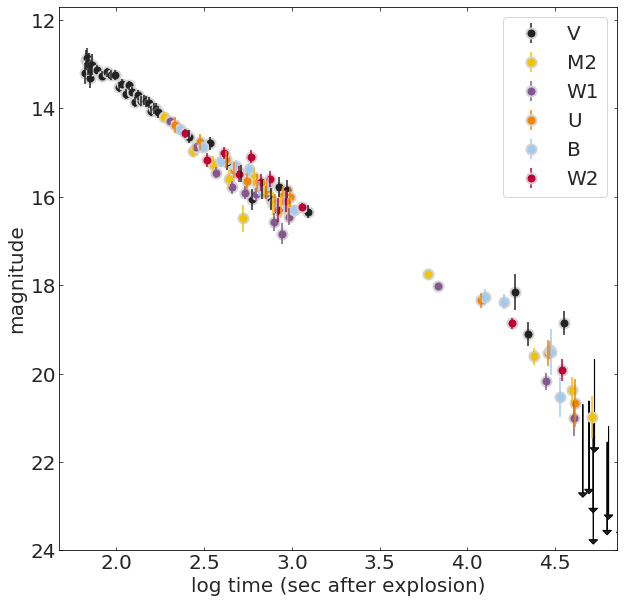

In [0]:
#create a figure container and an axis object inside of it
ax = pl.figure(figsize=(10,10)).add_subplot(111)

# creating the actual graph.  There's a lot of options I added to get as close 
# to the professors plot that I could get

# first, plotting with the different filters:
for f in grbAG["filter"].unique():
  pl.errorbar(grbAG.loc[grbAG["filter"]==f]["logtime"], grbAG.loc[grbAG["filter"]==f]["mag"],
              yerr=grbAG.loc[grbAG["filter"]==f]["magerr"], xerr=None,
              barsabove=True, fmt='.', mec='lightgrey', ms=20, mew=2)

# other adjustments made to the graph the professor made:
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime, 
             grbAG.loc[i].magerr, 0, 2, 
            head_width=0.05, head_length=0.1, ec='k')

# inverting the y axis, since we're measuring on magnitude
pl.ylim(24,11.7)          
pl.legend(grbAG["filter"].unique())

# axis labels
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time (sec after explosion)", fontsize=20);

Figure 1: Photometry of the Afterglow of GRB 052505A. All photometry is from the Swift satellite and it is obtained from Table 3 of Blustin et al. 2005 https://arxiv.org/pdf/astro-ph/0507515.pdf. The photometric band for each datapoint is indicated in the legend. Time is relative from the estimated moment of explosion of the stellar progenitor. Upperlimits are indicated by down-pointing arrows. (Description by Professor Bianco)

# **Solving using the Normal Equation**

Here, we're simply solving the Normal Equation:
$(X X^T)^{-1} X^T y = \beta$

In [0]:
x = grbAG[grbAG.upperlimit == 0].logtime.values

X = np.c_[np.ones((len(grbAG) - grbAG.upperlimit.sum(), 1)), x]  # prepping X

y = grbAG.loc[grbAG['upperlimit']==0]["mag"].values.reshape(-1, 1)   # reshape so it's the right format

In [0]:
theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)   # doing the normal equation

print ("best fit parameters from the Normal Equation: " +  
       "intercept {:.2f}, slope {:.2f}".format(theta_best[0][0], theta_best[1][0]))

best fit parameters from the Normal Equation: intercept 8.58, slope 2.51


# **Fit a line to the data (excluding the upper limits) with sklearn LinearRegression**

This is the same as above, instead we use the built in function supplied by sklearn instead of doing it by hand.


In [0]:
lr = LinearRegression()

In [0]:
lr.fit(X, y)
lrcoef = np.array([lr.intercept_[0], lr.coef_[0][1]])

In [0]:
print("best fit parameters from the sklearn LinearRegression(): " + 
       "intercept {:.2f}, slope {:.2f}".format(lrcoef[0], lrcoef[1]))

best fit parameters from the sklearn LinearRegression(): intercept 8.58, slope 2.51


# **Fit a line to the data (excluding the upper limits) by minimizing an objective function**

We'll choose the L1 metric to minimize on: \\
$ \sum_{i=1}^{n} |(a x + b) - y| $ \\
minimizing over a, b.

In [0]:
# NOTE: in my code, I have to do y.flatten() because of the way I structured it
def line(x, intercept, slope):
    return slope*x + intercept

def l1(args, x, y):
    a, b = args
    return sum(np.abs(line(x, a, b) - y.flatten()))


initialGuess = (10, 1) 

l1Solution = minimize(l1, initialGuess, args=(x, y))
l1coef = l1Solution.x
print("best fit parameters from the minimization of L1: " + 
       "slope {:.2f}, intercept {:.2f}".format(l1coef[1], l1coef[0]))

best fit parameters from the minimization of L1: slope 2.64, intercept 8.23


# **Fit a line to the data (excluding the upper limits) by minimizing an objective function that accounts for the measurements uncertainties**

Now we're doing our minimization over $\chi^2$: similar to L2, except dividing by errors: \\
$ \sum_{i=1}^{n} \frac{(a x + b) - y)^2}{\sigma_i^2}$ \\
minimizing over a, b.

In [0]:
def chi2(args, x, y, yerr):   # defining the X^2 objective function
  a, b = args
  return sum((line(x, a, b) - y.flatten())**2 / (yerr))

yerr = grbAG.loc[grbAG["upperlimit"]==0]["magerr"]

initialGuess = (10, 1) 

chi2Solution = minimize(chi2, initialGuess, args=(x, y, yerr))   # doing the minimization
sol = chi2Solution.x
print("best fit parameters from the minimization of the chi squared: " + 
       "slope {:.2f}, intercept {:.2f}".format(sol[1], sol[0]))

best fit parameters from the minimization of the chi squared: slope 2.50, intercept 8.58


# **Plotting all the solutions**

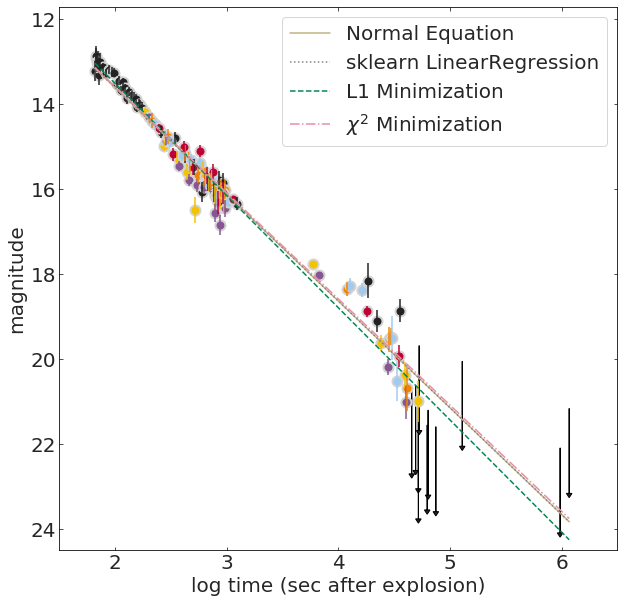

In [0]:
def plotline(x, vars, label, ls):
    temp = np.linspace(x[0], x[-1], 4)   # linspace to plot the actual lines
    ax.plot(temp, temp*vars[1] + vars[0], label=label, ls=ls)


ax = pl.figure(figsize=(10,10)).add_subplot(111)
x = grbAG["logtime"].values

# first, plotting with the different filters:
for f in grbAG["filter"].unique():
  pl.errorbar(grbAG.loc[grbAG["filter"]==f]["logtime"], grbAG.loc[grbAG["filter"]==f]["mag"],
              yerr=grbAG.loc[grbAG["filter"]==f]["magerr"], xerr=None,
              barsabove=True, fmt='.', mec='lightgrey', ms=20, mew=2)

# other adjustments made to the graph the professor made:
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime, 
             grbAG.loc[i].magerr, 0, 2, 
            head_width=0.05, head_length=0.1, ec='k')

#plot the models

#normal equation
plotline(x, theta_best.flatten(), "Normal Equation", "-")

#sklearn
plotline(x, lrcoef, "sklearn LinearRegression", ":")
         
#minimize L1
plotline(x, l1coef, "L1 Minimization", "--")
         
#minimize chi2
plotline(x, sol, "$\chi^2$ Minimization", "-.")
        
pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time (sec after explosion)", fontsize=20);



Figure 2: Same as Figure 1, but with linear regression models plotted. The models correspond to the best fit line to the data (excluding upper limits) calculated analytically by solving the normal equation, by solving the fit analysitcally with sklearn.LinearRegression(), and by minimizing the objective functions L1 and Chi squared. The models are indicated in the legend.  (Description by Professor Bianco)


# **Create a table with the results of each method**


| Method        | Slope           | Intercept  |
| ------------- |:-------------:| -----:|
| Normal Equations      | 2.51 | 8.58 |
| sklearn Linear Regression | 2.51      |   8.58 |
| L1 Minimization | 2.64      |    8.23 |
| $\chi^2$ Minimization | 2.50      |    8.58 |

Figure 3: Description of results of all regressions.  Note, as shown in Figure 2, the only regression that produced significatly different coefficients is the L1 regression.